In [1]:
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from machine_data.TDR2 import *
from postprocessing import *
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from machine_data.soleil import v2366, v2366_v2, v2366_v3, soleil
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from scipy.signal import periodogram

mbtrack2 version 0.6.0.106
--------------------------------------------------
If used in a publication, please cite mbtrack2 paper and the zenodo archive for the corresponding code version (and other papers for more specific features).
[1] A. Gamelin, W. Foosang, N. Yamamoto, V. Gubaidulin and R. Nagaoka, “mbtrack2”. Zenodo, Mar. 25, 2024. doi: 10.5281/zenodo.10871040.
[2] A. Gamelin, W. Foosang, and R. Nagaoka, “mbtrack2, a Collective Effect Library in Python”, presented at the 12th Int. Particle Accelerator Conf. (IPAC'21), Campinas, Brazil, May 2021, paper MOPAB070.




In [2]:
sol = soleil()
sol.emit*1e9

array([3.9  , 0.039])

In [2]:
ring = v2366_v3(IDs='open',)
ring.chro = [0.0, 0.0]
Q_S = ring.synchrotron_tune(1.7e6)
f"{ring.mcf[0]:.2e}"
def chro2xi(chro, ring, taub=14e-12):
    return chro*ring.omega0/ring.mcf[0]*taub
print(chro2xi(1.6, ring, taub = 4*14e-12))

4.458218361304202


In [3]:
def get_envelope(x, y, window_size=256):
    '''Return rolling maximum of signal y along time x.'''
    num_windows = len(x) // window_size
    indices = np.arange(0, num_windows * window_size, window_size)
    xm = indices + np.argmax(y[indices[:, None] + np.arange(window_size)], axis=1)
    ym = np.max(y[indices[:, None] + np.arange(window_size)], axis=1)
    return xm, ym

def exponential_func(t, A, B):
    '''Exponential function A * exp(B * t)'''
    return A * np.exp(B * t)

def exponential_fit(t, y):
    '''Fit y = A * exp(B * t) using least squares regression.'''
    # Initial guess for A and B
    A_init = y[0]
    B_init = np.log(y[-1] / y[0]) / (t[-1] - t[0])
    
    def model(params, t):
        A, B = params
        return A * np.exp(B * t)

    def residuals(params, t, y):
        return y - model(params, t)
    
    params_init = np.array([A_init, B_init])
    result = np.linalg.lstsq(np.vstack([np.exp(B_init * t), np.ones_like(t)]).T, y, rcond=None)[0]
    A, B = result[0], B_init

    return A, B

def fit_risetime(signal, smoothing_window_size=20, min_level=1,
                 until=None, start_from_0=False, min_points=500,
                 min_n_risetimes=1.5, matplotlib_axis=None):
    '''Fit the exponential rise time of a positive signal.'''
    start = 0 if start_from_0 else np.argmax(signal > min_level)
    to_be_fit = signal[start:until]

    t, x = get_envelope(np.arange(len(to_be_fit)), to_be_fit, window_size=smoothing_window_size)
    ddt = np.gradient(x, t)
    dddt = np.gradient(ddt, t)

    until = len(x)
    exponent = 0
    fit_start = 0 if start_from_0 else np.argmax((ddt[:-2] > 0) & (ddt[1:-1] > 0) & (ddt[2:] > 0))
    
    while exponent < min_n_risetimes / t[until-1]:
        try:
            until = np.where(
                (ddt[:-2] < 0) & (ddt[1:-1] < 0) & (ddt[2:] < 0) &
                (np.arange(len(ddt)-2) > fit_start + min_points)
            )[0][0]
            until_from_curvature = np.where(
                (dddt[:-2] < 0)& (dddt[1:-1] < 0) & (dddt[2:] < 0) &
                (np.arange(len(dddt)-2) > fit_start + min_points)
            )[0][0]
            until = min(until, until_from_curvature)
        except IndexError:
            until = len(x)

        if until == len(t):
            until -= 1
        amplitude, exponent = exponential_fit(t[fit_start:until], x[fit_start:until])
        if until >= len(x) - 1:
            break
        else:
            min_points += 1

    if matplotlib_axis:
        matplotlib_axis.plot(signal[:int(t[until] + start)])
        tplot = np.linspace(t[fit_start], t[until], 100)
        matplotlib_axis.plot(start + tplot, exponential_func(tplot, amplitude, exponent), color='cyan', ls='--')
        matplotlib_axis.axvline(start + t[fit_start], 0, 1, color='red', ls='dashed')
        matplotlib_axis.axvline(start + t[until], 0, 1, color='red', ls='dashed')

    return 1 / exponent

In [4]:
class DataProcessor():
    def __init__(self, folder):
        self.data = {}
        self.folder = folder
    def read_hdf5(self, filename):
        with hp.File(self.folder + filename) as f:
            (self.data['x'], self.data['xp'],
             self.data['y'], self.data['yp'],
             self.data['z'], self.data['dp']) = np.array(f['BunchData_0']['mean'][:])
            (self.data['sig_x'], self.data['sig_xp'],
             self.data['sig_y'], self.data['sig_yp'],
             self.data['sig_z'], self.data['sig_dp']) = np.array(f['BunchData_0']['std'][:])
            (self.data['Jx'], self.data['Jy'], self.data['Jz']) = np.array(f['BunchData_0']['cs_invariant'][:])
            (self.data['emit_x'], self.data['emit_y'], self.data['emit_z'] ) = np.array(f['BunchData_0']['emit'][:])
        for key in self.data.keys():
            self.data[key] = np.trim_zeros(self.data[key], trim='b')
            
    def get_risetime(self, ax=None):
        data = (self.data['Jy'][op.data['Jy']/op.data['sig_y'][0] < 1_000_000 ])/self.data['sig_y'][0]
        risetime = fit_risetime(data,
                                smoothing_window_size=20,
                                min_level = 1,
                                min_points = 100, 
                                min_n_risetimes = 3,
                                matplotlib_axis=ax)
        return 2*risetime
        

In [5]:
op = DataProcessor("/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/sbi/")


In [6]:
filename = (f"monitors(n_mp={1e6:.1e},"+
            f"n_turns={5e4:.1e},"+
            f"n_bin=100,bunch_current={5e-3:.1e},"+
            f"Qp_x={0:.2f},Qp_y={0:.2f},id_state={'close':},"+
            f"Zlong={'True':},"+
            f"cavity={'False':},"+
            f"max_kick={0:.1e}"+
            f",sc={'False':}"+
            ").hdf5")
op.read_hdf5(filename)

CPU times: user 25.4 ms, sys: 512 µs, total: 25.9 ms
Wall time: 24.8 ms


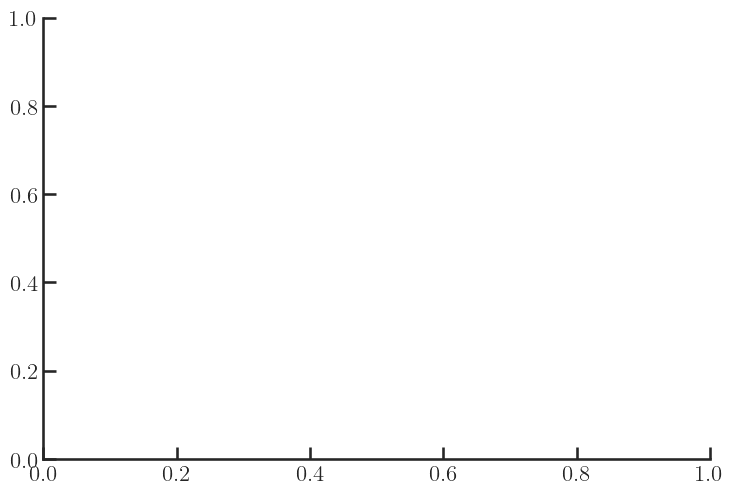

In [16]:
%%time
fig, ax = plt.subplots(1, 1)
ax.plot(op.data['emit_y'])
# ax.plot(op.data['emit_y'])
# ax.plot(op.data['y']/op.data['sig_y'][0])
# ax.set_xlim(25_000, 50_000)
# ax.set_ylim(0, )
# rt = op.get_risetime(ax)
# ax.set_yscale('log')


In [56]:
%matplotlib inline
n_macroparticles=1e6
n_turns = 5e4
n_bin = 100
bunch_current = 1.4e-3
Qp_x = 0.0
Qp_y = 0.0

ID_state = 'close'
Zlong='True'
cavity='False'
tmci_current = 1e-3*np.linspace(0.2, 7, 35)
# tmci_current = 1e-3 * np.linspace(12, 25, 14)
# tmci_current = 1e-3 * np.linspace(12, 20, 9)
# tmci_current = 1e-3*np.linspace(0.2, 12, 60)
# tmci_current  = 1e-3*np.linspace(0.2, 10, 50)
risetimes = []
peak_freqsarr = []
peak_ampsarr = []
sigmas_dp = []
sigmas_dp_min = []
sigmas_dp_max = []

sigmas_z = []

for bunch_current in tqdm(tmci_current):
    try:
        risetime, peak_freqs, peak_amps, final_energy_offset, max_energy_offset, min_energy_offset, final_bunch_length = post_single(n_macroparticles,
                    n_turns, 
                    n_bin,
                    bunch_current, 
                    Qp_x,
                    Qp_y,
                    ID_state,
                    Zlong,
                    cavity,
                    max_kick=0,
                    sc='True')
    except:
        print('Exception occured')
        risetime = peak_freqs = peak_amps = final_energy_offset = max_energy_offset = min_energy_offset = final_bunch_length = np.nan
    risetimes.append(risetime)
    peak_freqsarr.append(np.array(peak_freqs))
    peak_ampsarr.append(np.array(peak_amps))
    sigmas_dp.append(final_energy_offset)
    sigmas_z.append(final_bunch_length)    
    sigmas_dp_min.append(min_energy_offset)
    sigmas_dp_max.append(max_energy_offset)

  0%|          | 0/35 [00:00<?, ?it/s]

/home/gubaidulin/anaconda3/lib/python3.9/site-packages/FITX/fitting.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  while exponent < min_n_risetimes / t[until-1]:
/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


Exception occured


/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


Exception occured


/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


Exception occured


/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


Exception occured


/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


Exception occured


/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


Exception occured


/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


Exception occured


/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


Exception occured
Exception occured


/home/gubaidulin/scripts/tracking/transverse_instabilities/src/postprocessing/postprocessing.py:97: RuntimeWarning: Mean of empty slice
  final_energy_offset = np.nanmean(


In [59]:
%matplotlib inline
risetimes = np.array(risetimes)
risetimes = np.nan_to_num(risetimes)
# risetimes_sc_tmci = risetimes
# risetimes_no_sc_tmci = risetimes
# np.save('tmci_sc_hc', risetimes)
# peak_freqsarr[-8] = (peak_ampsarr[-7] + peak_ampsarr[-9])/2
# peak_freqsarr[0] = np.zeros(len(peak_ampsarr[1]))
# peak_ampsarr[-8] = (peak_ampsarr[-7] + peak_ampsarr[-9])/2
# peak_ampsarr[0] = np.zeros(len(peak_ampsarr[1]))
# peak_ampsarr[0][1]  = 1
peak_freqsarr[:-9]

[array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4.9996e-01, 4.9998e-01,
        5.0000e-01]),
 array([0.0000e+00, 2.0000e-05, 4.0000e-05, ..., 4

[[5.50891064e-045 2.28466955e-021 1.31590913e-020 ... 1.71867390e-020
  4.20056099e-020 3.42984020e-020]
 [2.74654499e-046 1.16340698e-022 6.92942166e-021 ... 1.87449399e-020
  1.49609490e-020 9.82754682e-021]
 [9.23937735e-045 2.31472306e-021 1.34266876e-020 ... 2.92174533e-021
  1.43821574e-020 3.09329672e-020]
 ...
 [3.45087317e+064 4.07243559e+092 4.07243572e+092 ... 4.16143755e+092
  4.16143714e+092 2.08071850e+092]
 [4.46510637e+066 8.08265721e+092 8.08265990e+092 ... 6.18974473e+094
  6.18974442e+094 3.09487216e+094]
 [6.85340954e+079 9.80825420e+107 9.80825452e+107 ... 2.26741047e+108
  2.26741032e+108 1.13370513e+108]]
(26, 25001)


(0.295, 0.305)

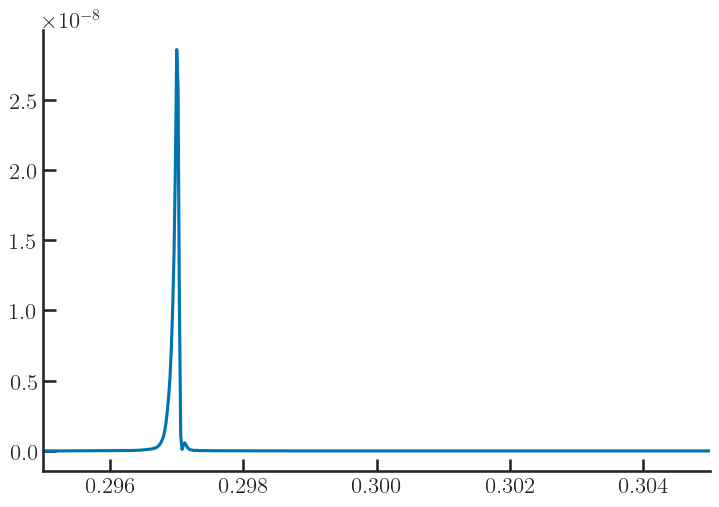

In [60]:
freqs = np.array(peak_freqsarr[:-9])
amps = np.array(peak_ampsarr[:-9])
print(amps)
print(freqs.shape)
plt.plot(freqs[10], amps[10])
plt.xlim(0.3-0.005, 0.3+0.005)

In [61]:
# print(amps)
for i in range(len(amps)):
    amps[i] /= max(amps[i])
# bunch_current = 1e-3 * np.linspace(0.2, 7, 35)
# bunch_current

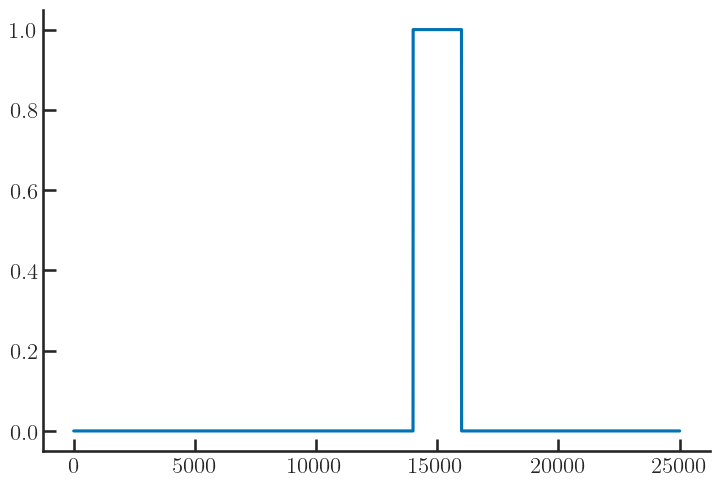

In [62]:
a = tmci_current.shape[0]
index = (freqs[1] < .32) & (freqs[1] > 0.28)
plt.plot(range(len(index)), index)

In [63]:
good_index = (freqs[1] < .32) & (freqs[1] > 0.28)
print(amps.shape, freqs.shape)
amps = amps[:, good_index]
freqs = freqs[:, good_index]

b = freqs[1].shape[0]
current = np.repeat(tmci_current[:-9]*1e3, b)
F = freqs.flatten()
A = amps.flatten()
T, F = np.meshgrid(tmci_current[:-9], freqs[1], indexing='ij')
print(T.shape, F.shape, amps.shape)

(26, 25001) (26, 25001)
(26, 1999) (26, 1999) (26, 1999)


(0.28, 0.301)

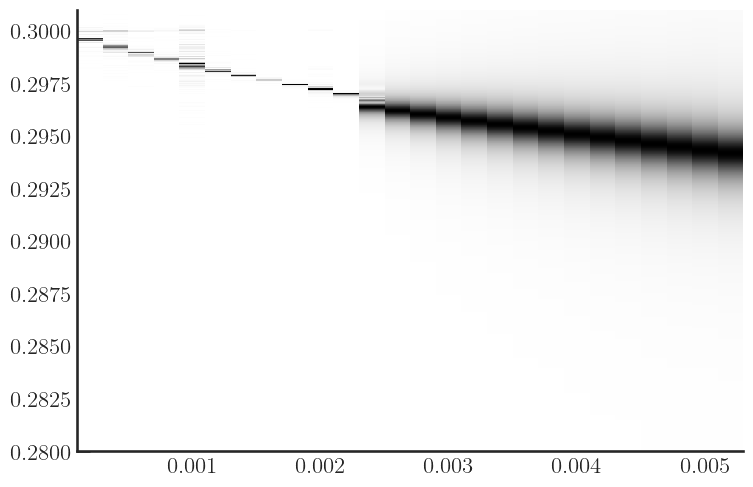

In [64]:

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(T, F, amps, cmap='binary', shading='auto')
ax.set_ylim(0.28, 0.301)

In [65]:
# np.save('fftT_sc', T)
# np.save('fftF_sc', F)
# np.save('fftamps_sc', amps)

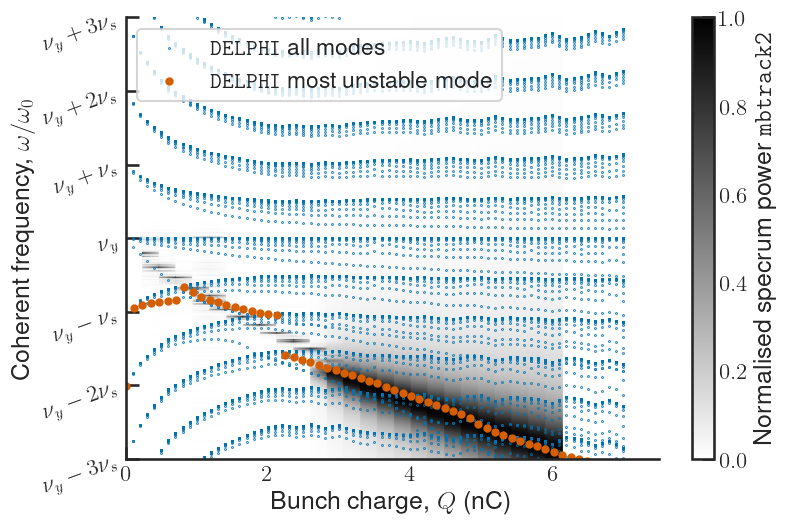

In [66]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
mesh = ax.pcolormesh(T*ring.T0*1e9, F, amps, cmap='binary', shading='gouraud')
Q_Y = .3
Q_S = 0.002
multiple_of = 3
ax.set_ylim(Q_Y - np.floor(Q_Y) - multiple_of * Q_S,
            Q_Y - np.floor(Q_Y) + multiple_of * Q_S)
ax.set_yticks(
    np.linspace(Q_Y - np.floor(Q_Y) - multiple_of * Q_S,
                Q_Y - np.floor(Q_Y) + multiple_of * Q_S,
                2 * multiple_of + 1))
labels = ['$\\nu_y-\\nu_s$', '$\\nu_y$', '$\\nu_y+\\nu_s$']
for i in range(2, multiple_of + 1):
    labels.insert(0, '$\\nu_y-{:}\\nu_s$'.format(i))
    labels.append('$\\nu_y+{:}\\nu_s$'.format(i))
ax.set_yticklabels(labels, rotation=20)

Q_s0 = 2.e-3
Q_s = 1.1e-3
sigma_z = 27e-12
Qp = 0.0
damper_gain = 0
ximp = 1.0
damper_gain = 0
df = pd.read_csv(f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z={sigma_z:.1e},ID=close,plane=vertical,Qp={Qp:.1f},M=1,Q_s={Q_s:.1e},n_max=0,damper_gain={damper_gain:.1e},ximpedance={ximp:.1f}).csv', sep='\t')
ax.scatter(1e3*df['BunchCurrent'], df['eigvals_re']+Q_Y, marker='.', s=1, color='b', label='\\texttt{DELPHI} all modes')
# ax.set_ylabel('$\mathrm{Re}\Delta Q/Q_{s_0}$')
df = df.drop_duplicates(['BunchCurrent'], keep='first')
ax.scatter(df['BunchCurrent']*ring.T0*1e9, df['eigvals_re']+Q_Y, marker='.', color='r', label='\\texttt{DELPHI} most unstable mode')
fig.colorbar(mesh, ax=[ax], label='Normalised specrum power \\texttt{mbtrack2}' )
ax.set_xlabel('Bunch charge, $Q$ (nC)')
ax.set_ylabel('Coherent frequency, $\omega/\omega_0$')
ax.set_xlim(0, 7.5)
plt.legend(loc='upper left', frameon=True)

In [70]:
new_data = pd.DataFrame(columns=['BunchCurrent(A)', 'Growthrate(1/turns)', 'SpaceCharge', 'Code'])
new_data['BunchCurrent(A)'] = 1e-3*np.linspace(0.2, 7, 35)
new_data['Growthrate(1/turns)'] = 1/(risetimes_no_sc_tmci)
new_data['SpaceCharge'] = np.zeros(35)
new_data['Code'] = ['mbtrack2']*35

tmp_data = pd.DataFrame(columns=['BunchCurrent(A)', 'Growthrate(1/turns)', 'SpaceCharge', 'Code'])
tmp_data['BunchCurrent(A)'] = 1e-3*np.linspace(0.2, 7, 35)
tmp_data['Growthrate(1/turns)'] = 1/(risetimes_sc_tmci)
tmp_data['SpaceCharge'] = np.ones(35)
tmp_data['Code'] = ['mbtrack2']*35

data = pd.concat([new_data, tmp_data], axis=0, ignore_index=False)
print(data)

    BunchCurrent(A)  Growthrate(1/turns)  SpaceCharge      Code
0            0.0002             0.000000          0.0  mbtrack2
1            0.0004             0.000000          0.0  mbtrack2
2            0.0006             0.000000          0.0  mbtrack2
3            0.0008             0.000547          0.0  mbtrack2
4            0.0010             0.001194          0.0  mbtrack2
..              ...                  ...          ...       ...
30           0.0062             0.005682          1.0  mbtrack2
31           0.0064             0.005885          1.0  mbtrack2
32           0.0066             0.006082          1.0  mbtrack2
33           0.0068             0.006292          1.0  mbtrack2
34           0.0070             0.006426          1.0  mbtrack2

[70 rows x 4 columns]


    Unnamed: 0  BunchCurrent(A)  Growthrate(1/turns)  SpaceCharge      Code
0            0           0.0002             0.000000          0.0  mbtrack2
1            1           0.0004             0.000000          0.0  mbtrack2
2            2           0.0006             0.000000          0.0  mbtrack2
3            3           0.0008             0.000547          0.0  mbtrack2
4            4           0.0010             0.001194          0.0  mbtrack2
..         ...              ...                  ...          ...       ...
65          30           0.0062             0.005682          1.0  mbtrack2
66          31           0.0064             0.005885          1.0  mbtrack2
67          32           0.0066             0.006082          1.0  mbtrack2
68          33           0.0068             0.006292          1.0  mbtrack2
69          34           0.0070             0.006426          1.0  mbtrack2

[70 rows x 5 columns]


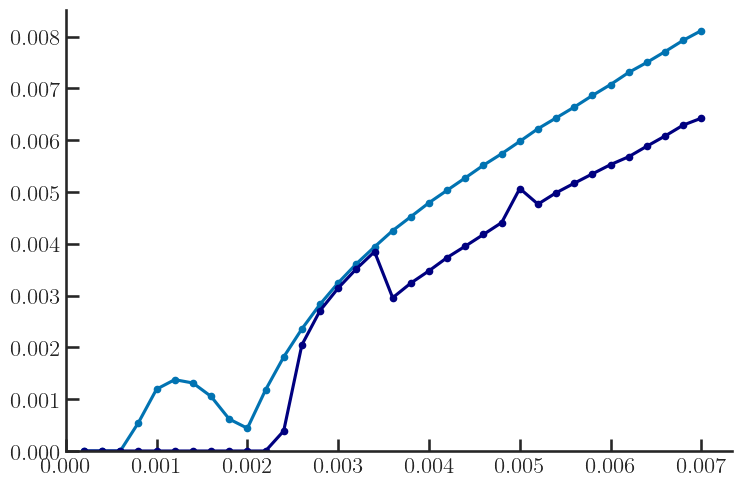

In [8]:
# data.to_csv('data_tmp.csv')
data = pd.read_csv('data_tmp.csv')
plt.plot(data[data['SpaceCharge']==0]['BunchCurrent(A)'], data[data['SpaceCharge']==0]['Growthrate(1/turns)'], marker='.', color='b')
plt.plot(data[data['SpaceCharge']==1]['BunchCurrent(A)'], data[data['SpaceCharge']==1]['Growthrate(1/turns)'], marker='.', color='navy')
plt.xlim(0, )
plt.ylim(0, )
risetimes_sc_tmci = 1/data[data['SpaceCharge']==1]['Growthrate(1/turns)']
risetimes_no_sc_tmci = 1/data[data['SpaceCharge']==0]['Growthrate(1/turns)']
# index = (data['SpaceCharge'] == 1.0) & (data['BunchCurrent(A)'] == 0.0066)
# data[index]['Growthrate(1/turns)'].value = np.nan
print(data)

/tmp/ipykernel_72994/3850160620.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tmci_current*ring.T0*1e9, 1/(risetimes_no_sc_tmci), lw=2, marker='.', color='b', label='\\texttt{mbtrack2} w/o SC')


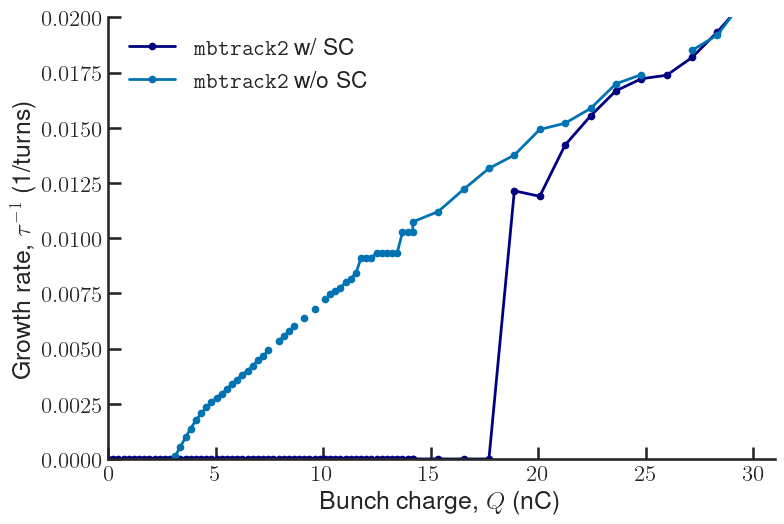

In [42]:
Q_s0 = 2.1e-3
sbs.color_palette('colorblind')
# risetimes_sc_tmci[17] = (risetimes_sc_tmci[16] + risetimes_sc_tmci[18])/2
# risetimes_no_sc_tmci[-8] = (risetimes_no_sc_tmci[-7] + risetimes_no_sc_tmci[-9])/2
# risetimes_sc_tmci[-9:] = np.nan
# risetimes_sc_tmci[19] = risetimes_sc_tmci[18] + risetimes_sc_tmci[18]-risetimes_sc_tmci[17]
# risetimes_no_sc_tmci[-3] = (risetimes_no_sc_tmci[-1] + risetimes_no_sc_tmci[-4]) * 0.5
# risetimes_no_sc_tmci[-2] = (risetimes_no_sc_tmci[-1] + risetimes_no_sc_tmci[-4]) *0.5

# plt.plot(tmci_current*ring.T0*1e9, 1/(2*np.pi*risetimes_sc_tmci*Q_s0), lw=2, marker='.', color='navy', label='\\texttt{mbtrack2} w/ SC')
# plt.plot(tmci_current*ring.T0*1e9, 1/(2*np.pi*risetimes_no_sc_tmci*Q_s0), lw=2, marker='.', color='b', label='\\texttt{mbtrack2} w/o SC')

# risetimes_sc_tmci = np.concatenate((np.load('sc_0-12.npy'), np.load('sc_12-20.npy')))
# risetimes_no_sc_tmci = np.concatenate((np.load('nosc_0-12.npy'), np.load('nosc_12-20.npy')))
# print(risetimes_sc_tmci)
# risetimes_sc_tmci[-2] = 0.5*(risetimes_sc_tmci[-1]+risetimes_sc_tmci[-3])
# risetimes_sc_tmci[risetimes_sc_tmci==0] = np.inf
tmci_current = 1e-3*np.concatenate((np.linspace(0, 12, 60), np.linspace(12, 25, 14)))
plt.plot(tmci_current*ring.T0*1e9, 1/(risetimes_sc_tmci), lw=2, marker='.', color='navy', label='\\texttt{mbtrack2} w/ SC')
plt.plot(tmci_current*ring.T0*1e9, 1/(risetimes_no_sc_tmci), lw=2, marker='.', color='b', label='\\texttt{mbtrack2} w/o SC')
# ximp = 1.0
# sig_z = 63e-12 #23e-12
# Q_s = 2.7e-4 #.95e-3
# colors = ['r',]
# for damper_gain in [0]:#, 5e-3, 1e-2, 2e-2]:
#     df = pd.read_csv(f'~/scripts/analytical/delphi/data/tmp/delphi(sigma_z={sig_z:.1e},ID=close,plane=vertical,Qp=0.0,M=1,Q_s={Q_s:.1e},n_max=0,damper_gain={damper_gain:.1e},ximpedance={ximp:.1f}).csv', sep='\t')
#     df['BunchLength'].unique()/4
#     df = df.drop_duplicates(['BunchCurrent'], keep='first')
#     plt.plot(df['BunchCurrent']/1e-3, -df['eigvals_im']/Q_s0, lw=2, marker='.',
#              # label=f'DELPHI g={damper_gain:.3f} (1/turns)',
#              label='\\texttt{DELPHI} w/o SC',
#              color='r'
#             )
plt.xlim(0, )
plt.ylim(0, .02)
# plt.xlabel('Bunch current, $I$ (mA)')
plt.xlabel('Bunch charge, $Q$ (nC)')

# plt.ylabel('Growth rate, $\Im\Delta Q_\mathrm{coh}/Q_{s_0}$')
plt.ylabel('Growth rate, $\\tau^{-1}$ (1/turns)')

# plt.title('Head-tail instability, w/ harmonic cavity')
plt.legend()
# plt.savefig('../../data/processed/tmci/ht_SC_nc_wo_hc.png')
# plt.savefig('../../data/processed/tmci/ht_SC_nc_wo_hc.pdf')

In [67]:
# risetimes_no_sc_tmci[-8] = (risetimes_no_sc_tmci[-7]+risetimes_no_sc_tmci[-9])/2
# risetimes_no_sc_tmci[-12] = (risetimes_no_sc_tmci[-13]+risetimes_no_sc_tmci[-11])/2
# print(risetimes_no_sc_tmci)
# risetimes_sc_tmci[-3] = (risetimes_sc_tmci[-4]+risetimes_sc_tmci[-2])/2

In [23]:
ring.mcf
f"{0.00010695:.2e}"

'1.07e-04'

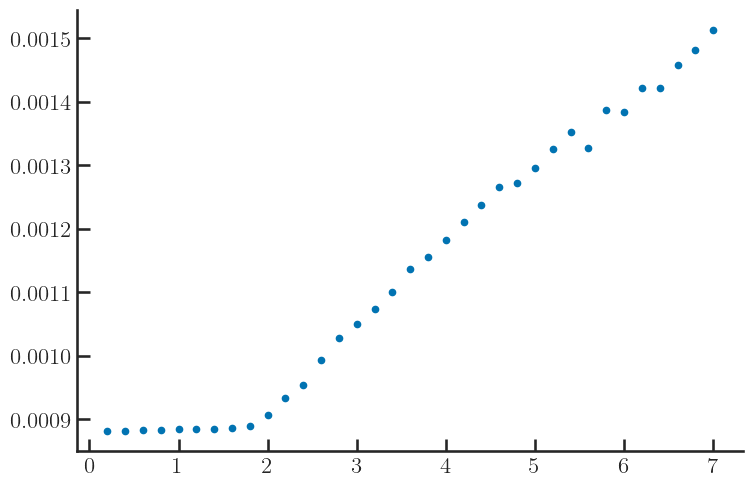

In [7]:
a = pd.DataFrame({'current': tmci_current*1e3, 'rms_bunch_length': sigmas_z, 'rms_energy_spread': sigmas_dp})
# a.loc[17, 'rms_energy_spread'] = np.nan
a['rms_energy_spread'] = a['rms_energy_spread'].interpolate()
plt.plot(tmci_current*1e3, a['rms_energy_spread'], marker='.', linewidth=0)


In [63]:
%matplotlib inline
# a.loc[17, 'rms_bunch_length'] = np.nan
# a.loc[1, 'rms_bunch_length'] = np.nan
a['rms_bunch_length'] = a['rms_bunch_length'].interpolate()
b = pd.concat([pd.DataFrame({'current': [0], 'rms_bunch_length': [ring.sigma_0], 'rms_energy_spread': [ring.sigma_delta]}), a])

(0.0, 7.34)

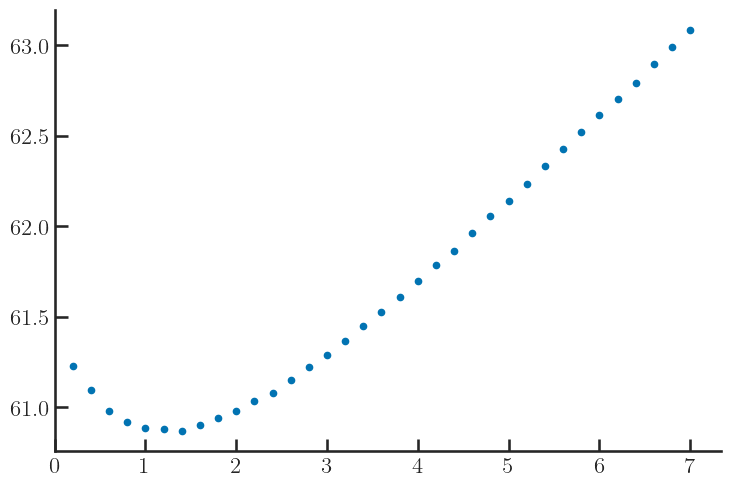

In [67]:
plt.plot(tmci_current*1e3, np.array(sigmas_z)/1e-12, marker='.', linewidth=0)
# sigz = np.load('/home/gubaidulin/scripts/analytical/delphi/input/sigmas_zlong.txt')
# plt.plot(np.linspace(0, 5e-3, 51)/1e-3, sigz/1e-12)
plt.xlim(0, )
# plt.ylim(0, )
# plt.plot(tmci_current*1e3, np.array(sigmas_z)/1e-12)


0.0008547


/tmp/ipykernel_2041601/3582196253.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  b['rms_energy_spread'][0] = ring.sigma_delta
/tmp/ipykernel_2041601/3582196253.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas

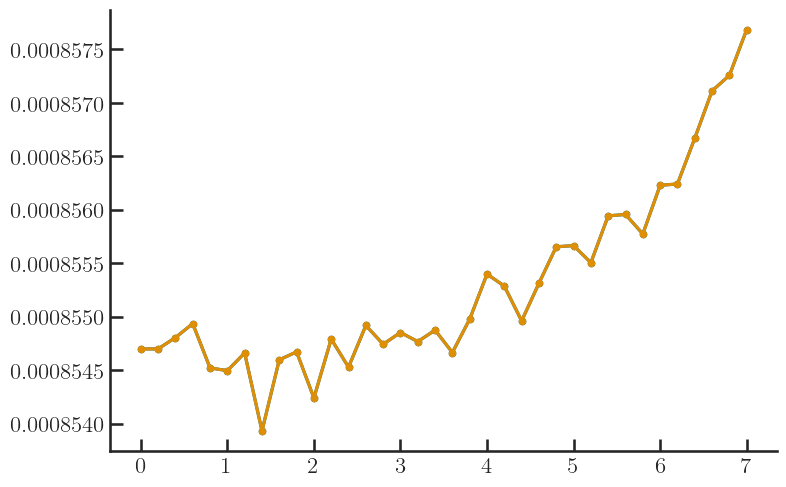

In [72]:
# plt.plot(b['current'], b['rms_bunch_length']/1e-12, marker='.')
plt.plot(b['current'], b['rms_energy_spread'], marker='.')
from machine_data import v2366_v3
ring = v2366_v3(IDs = 'close')
b['rms_energy_spread'][0] = ring.sigma_delta
b['rms_bunch_length'][0] = 61.55e-12

# b.to_csv('/home/gubaidulin/scripts/analytical/delphi/input/sigmas_hc.txt', sep='\t')
print(ring.sigma_delta)
plt.plot(b['current'], b['rms_energy_spread'], marker='.')


[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4 5.6 5.8 6.  6.2 6.4 6.6 6.8 7. ] [6.20000000e-11 6.15500000e-11 6.10922312e-11 6.09800156e-11
 6.09164958e-11 6.08867775e-11 6.08772237e-11 6.08687595e-11
 6.09001685e-11 6.09374788e-11 6.09768376e-11 6.10325046e-11
 6.10801326e-11 6.11497041e-11 6.12193079e-11 6.12900377e-11
 6.13675350e-11 6.14468726e-11 6.15267673e-11 6.16112022e-11
 6.16973091e-11 6.17857951e-11 6.18633138e-11 6.19635078e-11
 6.20539314e-11 6.21413167e-11 6.22302660e-11 6.23330496e-11
 6.24244994e-11 6.25179276e-11 6.26124590e-11 6.27034638e-11
 6.27915869e-11 6.28932116e-11 6.29872451e-11 6.30851154e-11]


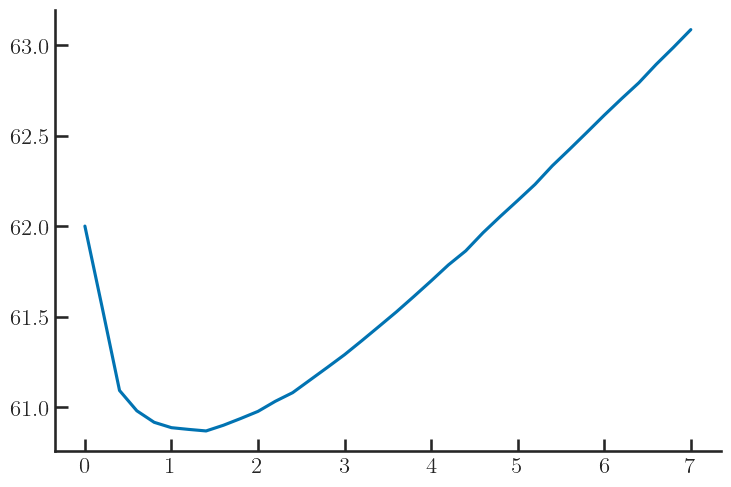

In [74]:
df_input = np.loadtxt('/home/gubaidulin/scripts/analytical/delphi/input/sigmas_hc.txt', delimiter='\t', usecols=(1, 2), dtype=np.float64, skiprows=1)
(Ib, sigmas) = df_input.T
print(Ib, sigmas)
from scipy.interpolate import interp1d
interp1d(Ib, sigmas)(0.1e-3)
plt.plot(Ib, sigmas*1e12)

In [11]:
# n_macroparticles = 1e6
# n_turns = 1e5 #5e4
# # n_turns_wake = 50
# Qp_x = 1.60
# Qp_y = 1.60
id_state = 'close'
# include_Zlong = 'True'
# harmonic_cavity = 'False'
# sc = 'True'
# bunch_current = 6.8e-3
# max_kick = 0.0

def get_params(n_macroparticles=1e6, n_turns=1e5, Qp_x=1.6, Qp_y = 1.6, id_state='close', include_Zlong='True', harmonic_cavity='False', sc='False', bunch_current=1.2e-3, max_kick = 0,):
    folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/sbi/'
    filename = (folder+
                f'monitors(n_mp={n_macroparticles:.1e},'+
                f'n_turns={n_turns:.1e},'+
                f'n_bin=100,bunch_current={bunch_current:.2e},'+
                f'Qp_x={Qp_x:.2f},Qp_y={Qp_y:.2f},id_state={id_state:},'+
                f'Zlong={include_Zlong:},'+
                f'cavity={harmonic_cavity:},'+
                f'max_kick={max_kick:.1e}'+
                f',sc={sc:}'+
                ').hdf5')
    with hp.File(filename):
        f = hp.File(filename
                   )
        print(f.keys())
        y = f['BunchData_0']['mean'][2, :]
        yp = f['BunchData_0']['mean'][3, :]
        sig_z = f['BunchData_0']['std'][4, :]
        Jy = f['BunchData_0']['cs_invariant'][1, :]
        y = np.trim_zeros(y)
        yp = np.trim_zeros(yp)

        sig_y = f['BunchData_0']['std'][2, 0]
    return y, yp, sig_y, sig_z
y, yp, sig_y, sig_z = get_params(bunch_current = 5.0e-3)
turns = np.linspace(0, n_turns, y.shape[0])
fig, ax = plt.subplots(1, 1)

risetime = plot_offset(ax,
            m=y,
            mp=yp,
            std=sig_y,
            n_macroparticles=n_macroparticles,
            n_turns=n_turns,
            n_bin=100,
            bunch_current=bunch_current,
            Qp_x=0.0,
            Qp_y=0.0,
            n_bunches=1,
            n_sampling = 1)
dQcoh = 1/(2*np.pi*risetime)
print(f'Coherent tune shift is {(dQcoh/Q_S):.1e}')
ring = v2366_v2(IDs=id_state)
dQrad = 1/(ring.tau[1]*ring.omega0)
print(f'Threshold current is {500/dQcoh*dQrad:.1f} mA')
print(f'Synchrotron period in turns {1/(2*np.pi*ring.synchrotron_tune(1.8e6)):.1f}')
ax.set_xlim(0, 2e4)
ax.set_ylim(-1e4, 1e4)
# plt.savefig(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/offset(Qp={Qp_y:.1f},n_turns_wake={n_turns_wake:}).png')


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/sbi/monitors(n_mp=1.0e+06,n_turns=1.0e+05,n_bin=100,bunch_current=5.00e-03,Qp_x=1.60,Qp_y=1.60,id_state=close,Zlong=True,cavity=False,max_kick=0.0e+00,sc=False).hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>
<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>


Text(0, 0.5, 'Beam c. m. offset, $y/\\sigma_y$')

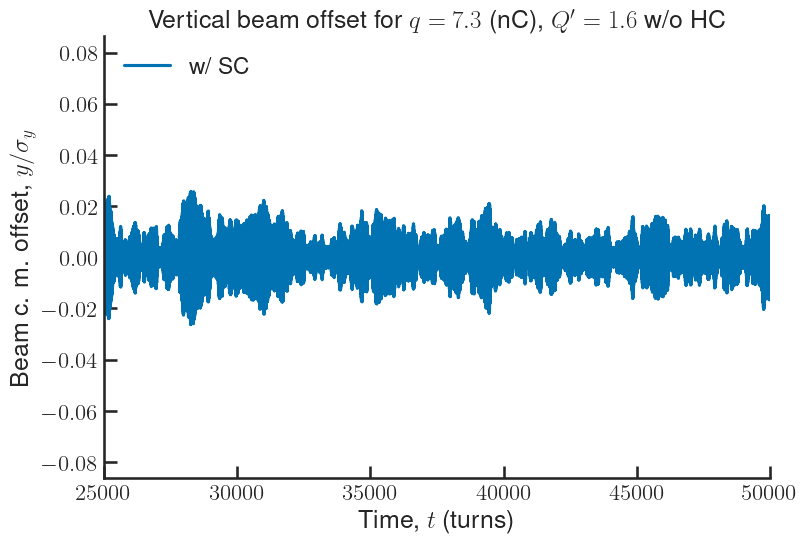

In [18]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
y, yp, sig_y, sig_z = get_params(bunch_current = 14e-3, sc='False', harmonic_cavity='False')
# ax.plot(y/sig_y, label='w/o SC')

y, yp, sig_y, sig_z = get_params(bunch_current = 14e-3, sc='True', harmonic_cavity='False')
ax.plot(y/sig_y, label='w/ SC')

plt.legend(loc='upper left')
# plt.plot(sig_z/1e-12)
ax.set_xlim(25_000, 50_000)
# ax.set_ylim(-2000, 2000)
q = 6.2e-3 * ring.T0 *1e9
q = 6.2e-3 * ring.T0 *1e9
ax.title.set_text(f"Vertical beam offset for $q={q:.1f}$ (nC), $Q'=1.6$ w/o HC")
ax.set_xlabel('Time, $t$ (turns)')
ax.set_ylabel('Beam c. m. offset, $y/\sigma_y$')
# plt.savefig('SOLEIL_hti_wo_hc_offset.pdf')

In [136]:
q = 6.25e-3 * ring.T0 *1e9
print(q)

7.379480173580618


(0.285, 0.315)

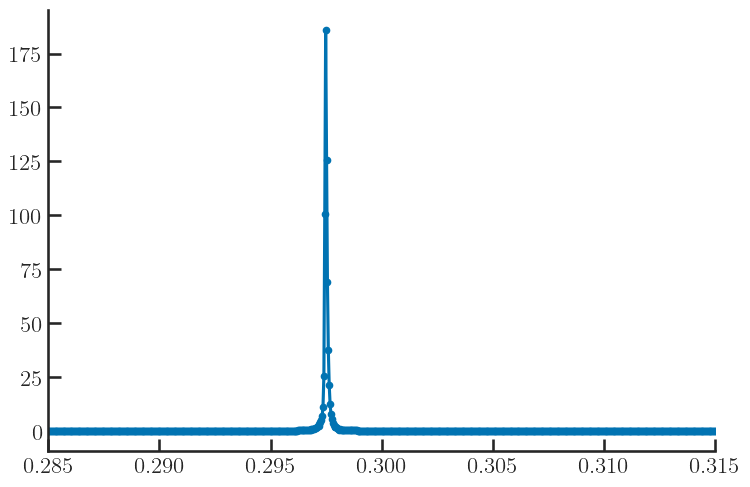

In [107]:
from scipy.signal import periodogram
f, A = periodogram(y[25_000:]/sig_y, fs=1, )
plt.plot(f, A, marker='.')
plt.xlim(0.3-0.015, 0.3+0.015)

In [143]:
with hp.File(filename) as f:
    print(f.keys())
    print(f['BunchData_0'].keys())
    print(f['WakePotentialData_0'].keys())
    m = f['BunchData_0']['mean'][:]
    std = f['BunchData_0']['std'][:]
    J = f['BunchData_0']['cs_invariant'][:]
    emit = f['BunchData_0']['emit'][:]
    p = f['WakePotentialData_0']['profile_Wydip'][:]
    tau = f['WakePotentialData_0']['tau_Wydip'][:]
    t = f['WakePotentialData_0']['time'][:]
    
    dip = f['WakePotentialData_0']['dipole_Wydip'][:]
    Wdip = f['WakePotentialData_0']['Wydip'][:]    
    time = f['WakePotentialData_0']['time'][:]

<KeysViewHDF5 ['BunchData_0', 'WakePotentialData_0']>
<KeysViewHDF5 ['cs_invariant', 'current', 'emit', 'mean', 'std', 'time']>
<KeysViewHDF5 ['Wydip', 'dipole_Wydip', 'profile_Wydip', 'tau_Wydip', 'time']>


(0.0, 30000.0)

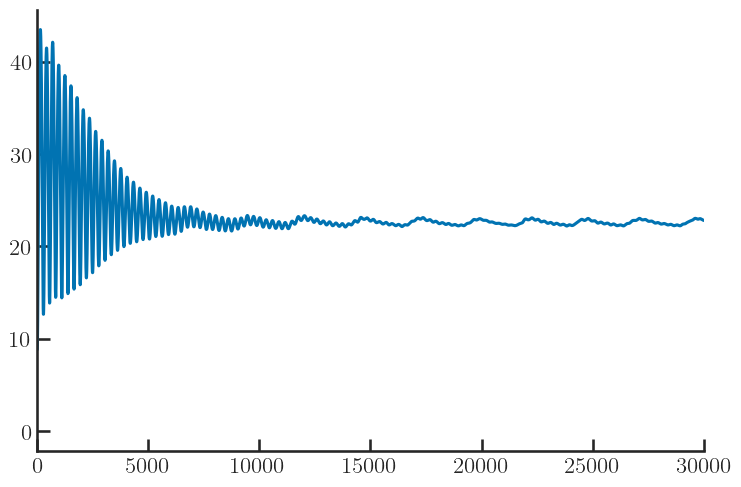

In [147]:
%matplotlib inline
plt.plot(std[4, :]/1e-12)
plt.xlim(0, 30_000)
# plt.ylim(1, 2)

/tmp/ipykernel_10151/986973462.py:6: RuntimeWarning: invalid value encountered in divide
  p_norm = p[:, 0]/np.max(p[:,0])


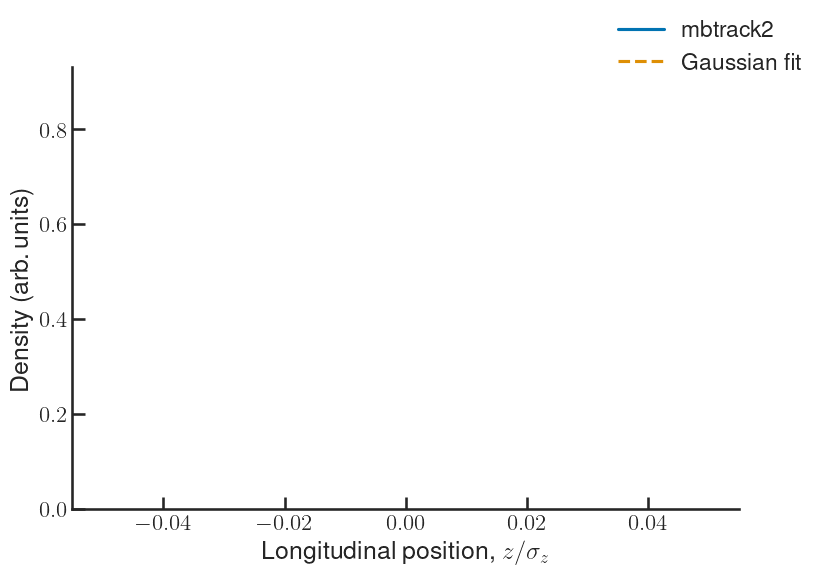

In [148]:
%matplotlib inline
from scipy.interpolate import interp1d


t = tau[:, 0]/std[4, 25_000]
p_norm = p[:, 0]/np.max(p[:,0])
t0 = np.linspace(-5, 5, 5000)
interp_fit = interp1d(t, p_norm)
# r2, popt = fit_loop(t0, interp_fit(t0))
fig, ax = plt.subplots(1, 1)
ax.plot(t, p_norm, label='mbtrack2')
plt.plot(t, np.exp(-.5*(t+.5)**2), linestyle='dashed', label='Gaussian fit')
# ax.plot(t0, laguerre_fit(t0, *popt), linestyle='dashdot', label='Laguerre fit')
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Density (arb.\,units)')

# ax.set_xlim(-4, 4)
ax.set_ylim(0, )
plt.figlegend()
# print("R-squared is {:.5f}".format(r2))
# plt.savefig('/hom

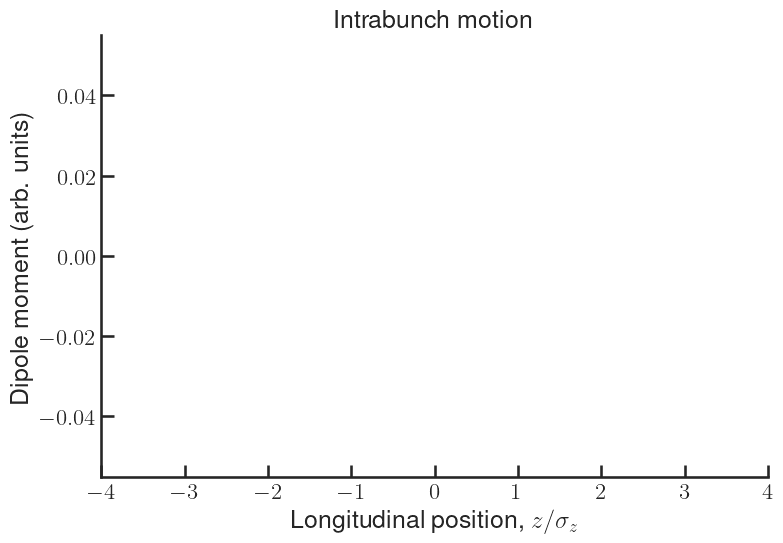

In [149]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
linenumber = 50
linestart = 2350
lineend = 2400
ax.plot(tau[:,linestart:lineend]/std[4, 25_000], dip[:,linestart:lineend]*p[:,linestart:lineend],
        color='black', alpha=0.5)
ax.set_xlim(-4, 4)
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Dipole moment (arb. units)')
# ax.title.set_text('Intrabunch motion for last {:} turns, N_m={:.1e}'.format(linenumber, n_macroparticles))
ax.title.set_text('Intrabunch motion')
# plt.savefig('ht_intrabunch_motion_3.0mA_no_sc.pdf')